In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
import math
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
%matplotlib inline  

In [2]:
# Plot font sizes

fs_labels = 26
fs_ticks = 25
fs_text = 23
fs_legend = 22

# Semi-visible jets

This notebook contains plots for our paper on dark parton showers at the LHC.

In [3]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None, kf=1.0):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000*kf

    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    return data

In [4]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=4, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]

    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [5]:
def get_bkg(bkg, cut=None):
    if cut is not None:
        new_bkg = bkg.query(cut)
    else: 
        new_bkg = bkg
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

def get_sig(sig, cut=None):
    if cut is not None:
        new_bkg = sig.query(cut)
    else: 
        new_bkg = sig
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

In [6]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

def signif(s, b ):
    return s/np.sqrt(s+b)

In [7]:
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0



## Background validation

Validate against IM1 signal region in the ATLAS monojet study (https://arxiv.org/abs/1704.03848).

In [8]:
cuts = 'MEt > 250 & pt1 > 250 & eta1 < 2.4 & eta1 > -2.4 & dphi > 0.4 & nj < 5'

### W+jets

In [9]:
Wj_df = combine_background_files('/mnt/hepheno/Dark-Showers/data/bkg_Wj/', nfiles=200, lumi = 3.2*1000, kf=1.0)

In [10]:
N = np.sum(np.histogram(Wj_df.query(cuts)['MEt'].values,weights=Wj_df.query(cuts)['weight'].values)[0])
print N, N*1.3

7882.64499791 10247.4384973


In [11]:
# ATLAS events
1710+1950+3980

7640

### Z+jets

In [12]:
Zj_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_Zj/', nfiles=200, lumi = 3.2*1000, kf=1.)

In [13]:
N = np.sum(np.histogram(Zj_df.query(cuts)['MEt'].values,weights=Zj_df.query(cuts)['weight'].values)[0])
print N, N*1.3

11400.6360258 14820.8268336


In [14]:
# ATLAS events
12520+48+76

12644

In [15]:
# K-factor
12644/11400.6360258

1.109060930581963

### $t\bar t$

In [16]:
tt_d_df = combine_background_files('/mnt/hepheno/Dark-Showers//data/bkg_ttbar_dilep//', nfiles=200, lumi = 3.2*1000, kf=1.)
tt_s_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_ttbar_semilep//', nfiles=200, lumi = 3.2*1000, kf=1.)

tt_df = pd.concat([tt_d_df, tt_s_df])

In [17]:
N = np.sum(np.histogram(tt_df.query(cuts)['MEt'].values,weights=tt_df.query(cuts)['weight'].values)[0])
print N, N*1.3

447.153346562 581.299350531


In [18]:
# ATLAS events
780

780

In [19]:
#K-factor
780/447.153346562

1.7443680249675804

## Fig. 6: SM background distributions

In [20]:
Zj_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_Zj/', nfiles=1000, kf=1.1)
Wj_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_Wj/', nfiles=1000, kf=1.0)
tt_d_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_ttbar_dilep//', nfiles=1000, kf=1.7)
tt_s_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_ttbar_semilep//', nfiles=1000, kf=1.7)
QCD_df = combine_background_files('/mnt/hepheno/Dark-Showers/data//bkg_qcd//', nfiles=2000, kf=1.0)

tt_df = pd.concat([tt_d_df, tt_s_df])
ewk_df = pd.concat([Zj_df, Wj_df])

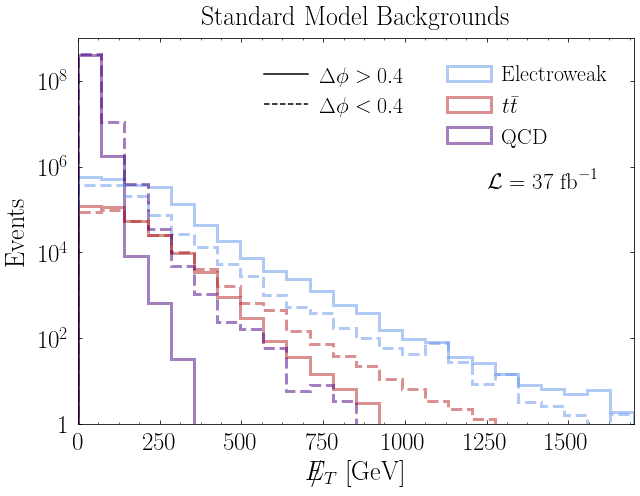

In [21]:
title = "Standard Model Backgrounds"
bins = np.linspace(0,1700,25)
normed = False
plt.figure(figsize=(9,7))
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'dphi > 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colors[0])

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colors[2])

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colors[3])

cut = 'dphi < 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[0], ls='--')

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3,  normed=normed, color=plot_colors[2], ls='--')

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[3], ls='--')

plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=fs_labels)

plt.ylim(1e0,1e9)
plt.title(title, fontsize=fs_labels)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


handles,labels = ax.get_legend_handles_labels()
handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],alpha=0)] + [Line2D([],[],alpha=0)] + [handles[i] for i in range(3)] #, handles[2]]
labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)
plt.xlim(0,1700)
plt.text(1250,3*10**5,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)

plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

plt.ylabel("Events",fontsize = fs_labels)
plt.yscale("log")
ax.set_yscale("log")
# ax.get_yaxis().set_major_formatter(ScalarFormatter())
# ax.yaxis.major.formatter.set_powerlimits((-4,-3))

# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,3))

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.tight_layout()

# plt.savefig("backgrounds_met.pdf")

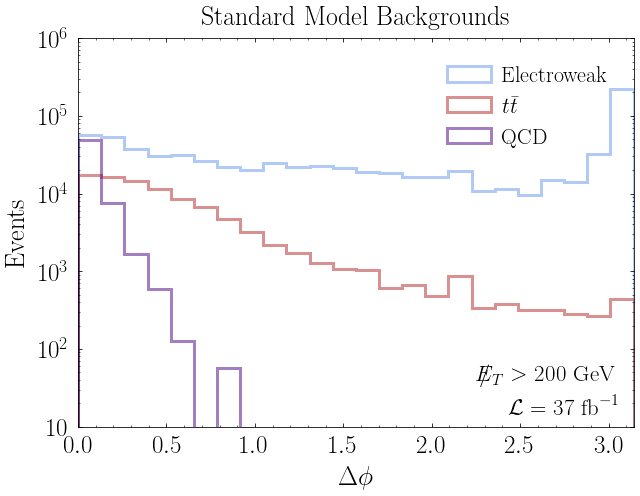

In [22]:
bins = np.linspace(0,np.pi,25)
normed = False
fig=plt.figure(figsize=(9,7))
plot_colorsss=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'MEt > 200'

plt.hist(ewk_df.query(cut)['dphi'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colorsss[0])

plt.hist(tt_df.query(cut)['dphi'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colorsss[2])

plt.hist(QCD_df.query(cut)['dphi'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colorsss[3])


plt.ylim(10,1e6)
ax = plt.gca()

plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])



handles,labels = ax.get_legend_handles_labels()
# handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color=plot_colorss[i],alpha=0)] + [Line2D([],[],color=plot_colorss[i],alpha=0)] + [Line2D([],[],color=plot_colorss[i]) for i in range(4)] #, handles[2]]
# labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.tick_params(axis='both', which='major', labelsize=fs_ticks)
plt.xlabel("$\Delta\phi$",fontsize=fs_labels)
plt.tight_layout()
plt.ylabel("Events",fontsize=fs_labels)
plt.yscale("log")
plt.xlim(0,np.pi)
plt.text(2.43,14,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
plt.text(2.25,35,"$\slash \!\!\!\! E_{T} >$ 200 GeV",fontsize=fs_text)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.tight_layout()
# plt.savefig("backgrounds_dphi.pdf")

## Fig. 5: Contact operator distributions

In [40]:
pd.read_csv("/mnt/hepheno/Dark-Showers/data//sig_zprime/events_mht2_smear_100000_.3_1.evt")

,evt,MEt,mjj,Mt,pt1,eta1,y1,pt2,eta2,y2,...,eta3,y3,pt4,eta4,y4,dphi,nj,n_meson,n_glu,weight
0,0,37.70440,298.0560,343.245,136.1910,-0.655533,-0.655533,113.4700,0.663161,0.663161,...,-1.647770,-1.647770,42.0561,-0.467100,-0.467100,0.133539,4,10,0,5.592870e-09
1,1,8.53311,142.0940,166.312,73.2741,1.559740,1.559740,65.7130,1.999470,1.999470,...,999.000000,0.000000,-1.0000,999.000000,0.000000,0.511235,2,0,0,5.592870e-09
2,2,20.33760,161.9420,221.584,85.5140,2.158500,2.158500,69.7635,1.518550,1.518550,...,999.000000,0.000000,-1.0000,999.000000,0.000000,0.772577,2,0,0,5.592870e-09
3,3,40.63080,146.2570,237.026,55.9248,2.515200,2.515200,34.2484,0.226394,0.226394,...,999.000000,0.000000,-1.0000,999.000000,0.000000,1.289280,2,0,0,5.592870e-09
4,4,210.98800,380.1400,724.413,346.7900,0.884731,0.884731,104.0450,1.021680,1.021680,...,-0.261155,-0.261155,-1.0000,999.000000,0.000000,0.028519,3,16,0,5.592870e-09
5,5,75.91010,312.2450,548.981,144.6750,1.645350,1.645350,139.5400,2.559220,2.559220,...,1.371200,1.371200,-1.0000,999.000000,0.000000,0.131544,3,10,0,5.592870e-09
6,6,46.71890,501.5300,550.473,246.3130,-0.305368,-0.305368,254.1550,-0.110700,-0.110700,...,-0.063402,-0.063402,157.2210,-0.598159,-0.598159,0.426021,4,14,0,5.592870e-09
7,7,21.37580,595.4970,620.957,241.3880,1.255570,1.255570,202.3890,-0.366734,-0.366734,...,1.848700,1.848700,-1.0000,999.000000,0.000000,1.288530,3,14,0,5.592870e-09
8,8,166.27700,905.1490,1193.380,622.6210,0.253888,0.253888,384.9630,0.542885,0.542885,...,-0.412410,-0.412410,83.9843,-0.148607,-0.148607,0.416591,8,20,0,5.592870e-09
9,9,271.39800,208.0420,758.817,118.5760,2.246000,2.246000,129.8610,0.722855,0.722855,...,999.000000,0.000000,-1.0000,999.000000,0.000000,3.030460,2,16,0,5.592870e-09


In [54]:
rinvs = [.00, .3, .6, 1.0 ]

sig10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime//', 100000, rinv,nfiles=10, extra = 'fiducial2_') for rinv in rinvs  ]
cxn10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv ,return_cxn=True,nfiles=10, extra = 'fiducial2_')[1] for rinv in rinvs ]

sig100 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv,nfiles=10, extra = 'mht2_') for rinv in rinvs  ]
cxn100 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv,nfiles=10, extra = 'mht2_',return_cxn=True)[1] for rinv in rinvs  ]

sig1000 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv,nfiles=10, extra = 'mht2_smear_') for rinv in rinvs  ]
cxn1000 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv,nfiles=10, extra = 'mht2_smear_',return_cxn=True)[1] for rinv in rinvs  ]

In [55]:
# sig10_lambda10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime//', 100000, rinv,nfiles=12, extra='lambda10_') for rinv in rinvs  ]
# cxn10_lambda10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data//sig_zprime/', 100000, rinv ,return_cxn=True,nfiles=12, extra='lambda10_')[1] for rinv in rinvs ]

In [56]:
plot_colorss=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']

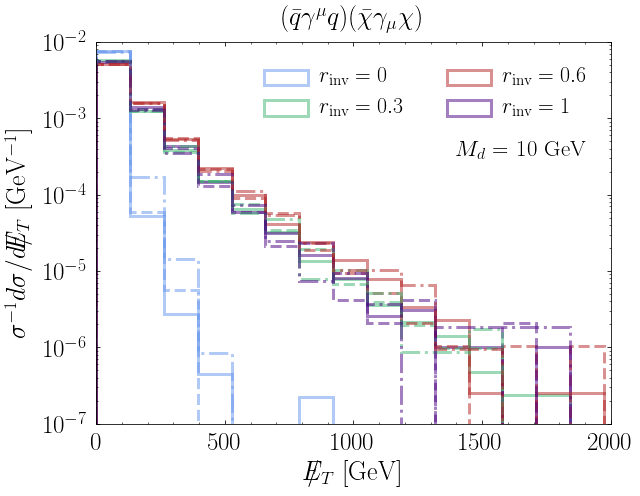

In [60]:
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"

lumi = 37000
bins = bins=np.linspace(0,2500,20)
fig=plt.figure(figsize=(9,7))
bw = bins[12]-bins[11] # bin width

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['MEt'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig100[irinv]['MEt'], weights=len(sig100[irinv])*[1/len(sig100[irinv])/bw], lw=3, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig1000[irinv]['MEt'], weights=len(sig1000[irinv])*[1/len(sig1000[irinv])/bw], lw=3, ls = '-.', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

# for irinv, rinv in enumerate(rinvs):
#     plt.hist(sig10[irinv]['MEt'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=fs_labels)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=fs_labels)  
plt.xlim([0,2000])


plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in range(4)] #, handles[2]]
labels = [labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.text(1400, 0.0003, "$M_d$ = 10 GeV",fontsize=fs_text)
plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))
plt.ylim(1e-7,1e-2)
plt.tight_layout()
# plt.savefig("contact_met.pdf")

In [71]:
labels=['default','\\texttt{delphes\_card\_CMS\_theory\_mht2.tcl}','\\texttt{delphes\_card\_CMS\_theory\_mht2\_smear.tcl}']

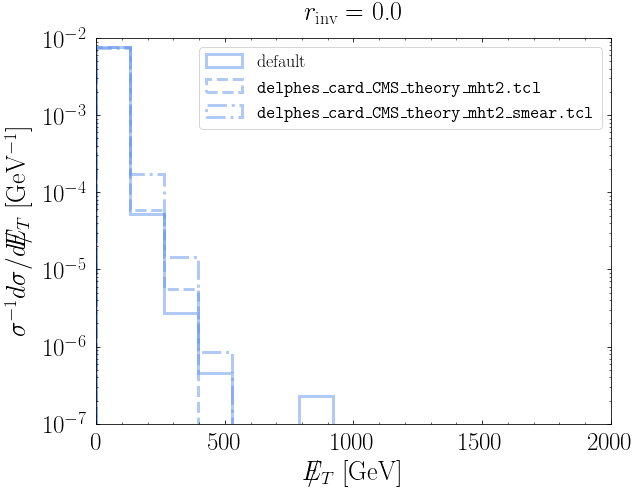

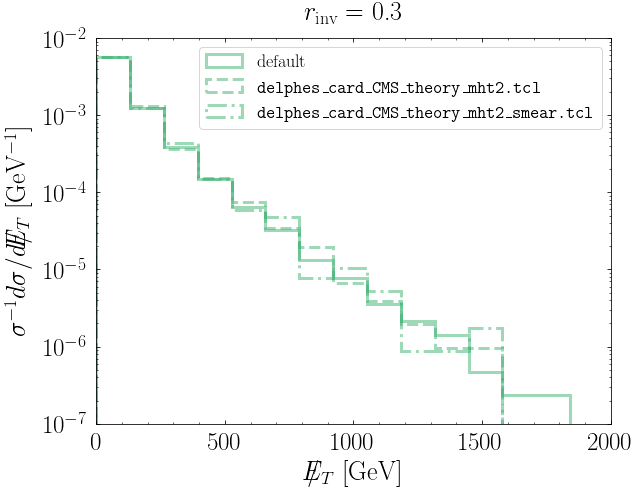

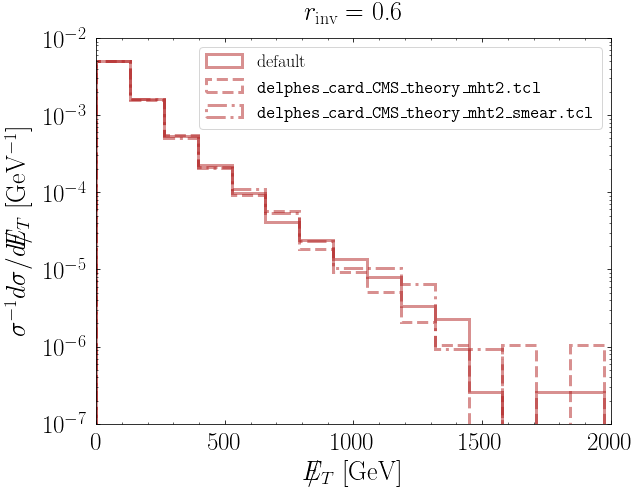

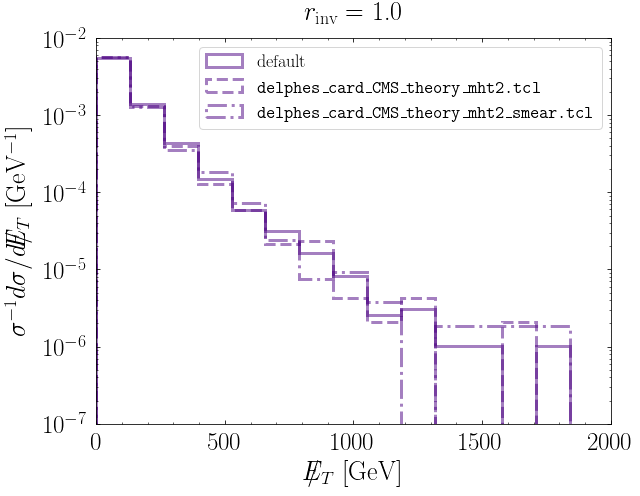

In [82]:
for irinv, rinv in enumerate(rinvs):
    title = "$r_\mathrm{inv} =$ " + str(rinv)

    lumi = 37000
    bins = bins=np.linspace(0,2500,20)
    fig=plt.figure(figsize=(9,7))
    bw = bins[12]-bins[11] # bin width


    plt.hist(sig10[irinv]['MEt'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = 'solid', label=labels[0], histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

    plt.hist(sig100[irinv]['MEt'], weights=len(sig100[irinv])*[1/len(sig100[irinv])/bw], lw=3, ls = '--', label=labels[1], histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

    plt.hist(sig1000[irinv]['MEt'], weights=len(sig1000[irinv])*[1/len(sig1000[irinv])/bw], lw=3, ls = '-.', label=labels[2], histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

    # for irinv, rinv in enumerate(rinvs):
    #     plt.hist(sig10[irinv]['MEt'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)



    plt.yscale('log', nonposy='clip')
    plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=fs_labels)
    plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=fs_labels)  
    plt.xlim([0,2000])


    plt.title(title, fontsize=fs_labels)
    ax = plt.gca()
    ttl = ax.title
    ttl.set_position([.5, 1.02])

#     handles,labels = ax.get_legend_handles_labels()
#     handles = [handles[i] for i in range(4)] #, handles[2]]
#     labels = [labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
#     leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
#                fontsize=fs_legend, ncol=2,frameon=False,
#                handletextpad=.5,
#                borderaxespad=0.)
    plt.legend()
#     plt.text(1400, 0.0003, "$M_d$ = 10 GeV, $r_\mathrm{inv}$ = " + str(rinv),fontsize=fs_text)
    plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))
    plt.ylim(1e-7,1e-2)
    plt.tight_layout()
    # plt.savefig("contact_met.pdf")
    
    plt.show()

In [ ]:
# Testing black and white appropriateness
# from PIL import Image
# Image.open('met_sig.png').convert('LA')

In [ ]:
lumi = 37000
bins=np.linspace(0,np.pi,20)
fig=plt.figure(figsize=(9,7))
bw = bins[12]-bins[11] # bin width
cut = 'MEt > 0'
for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['dphi'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

#     plt.hist(sig100[irinv].query(cut)['dphi'], weights=sig100[irinv].query(cut)['weight'].values/cxn100[irinv]/lumi, lw=0, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\Delta\phi$',fontsize=fs_labels)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\Delta\phi$',fontsize=fs_labels)  
plt.xlim([0,np.pi])
# plt.ylim(10**0,10**3)

plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in range(4)] #, handles[2]]
labels = [labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.text(2.27, 2.85, "$M_d$ = 10 GeV",fontsize=fs_text)
plt.ylim(0.016,25)
plt.tick_params(axis='both', which='major', labelsize=fs_labels)
plt.tight_layout()
# plt.savefig("contact_dphi.pdf")

In [ ]:
# make histograms
def newfig(name):
    fig=plt.figure(name,figsize=(9,7))
    plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

    
def plot_met_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")
    bins=np.linspace(0,2500,20)
    bw = bins[12]-bins[11]
    cell.hist(sig['MEt'], weights=len(sig)*[1/len(sig)/bw], 
             bins=bins,
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,2500])
    cell.set_yscale('log', nonposy='clip')

def plot_dphi_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")
    bins=np.linspace(0,np.pi,20)
    bw = bins[1]-bins[0]
    cell.hist(sig['dphi'], weights=len(sig)*[1/len(sig)/bw],  
             bins=bins,
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,np.pi])
    cell.set_yscale('log', nonposy='clip')

## Fig. 7: Contact operator limits

In [32]:
bkgs = [Zj_df, Wj_df, tt_d_df, tt_s_df, QCD_df]

In [33]:
cutlist=[]
basecut = 'pt1 > 250 & '

for MEtcut in [400,600,800,1000,1200]:
    for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
        # Do not let MET cut go < 800 if dphi < 0.4
        if dphicut == 'dphi < 0.4' and MEtcut < 800: continue 
        c1 = 'MEt > ' + str(MEtcut) + ' & '
        cutlist =  cutlist + [basecut + c1 + dphicut ]

In [34]:
bkg_list= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist) ] 

100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


In [ ]:
masses = [100000]
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [ ]:
cxn10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn100 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime////', 100000, rinv, extra = '100_', nfiles=16,return_cxn=True)[1] for rinv in rinvs  ]

cxn10_lambda10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'lambda10_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_lambda2p5 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'lambda2p5_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]

cxn10_NFf3 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'NFf3_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_NFf5 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'NFf5_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_NFf8 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'Nf8_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_NFf10 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'NFf10_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]


cxn10_mdm20 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'md20_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_mdm5 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'md5_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_mdm50 = [ combine_signal_files('/mnt/hepheno/Dark-Showers/data/sig_zprime///', 100000, rinv, extra = 'md50_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]

In [ ]:
cxn10_Nc3 = [ combine_signal_files('../data/sig_zprime///', 100000, rinv, extra = 'Nc3_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_Nc5 = [ combine_signal_files('../data/sig_zprime///', 100000, rinv, extra = 'Nc5_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn10_Nc10 = [ combine_signal_files('../data/sig_zprime///', 100000, rinv, extra = 'Nc10_' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]


In [ ]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$ -- varying $\Lambda_d$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r, extra = '', nfiles=16);

    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

contact_cxn_less = result_less*cxn10
contact_cxn_gtr = result_gtr*cxn10


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$\Lambda_d = 5~\mathrm{GeV~(baseline)}$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'lambda10_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_lambda10, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_lambda10, lw=3.5,
                 color='firebrick', label=r'$\Lambda_d = 10 ~\mathrm{GeV}$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'lambda2p5_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_lambda2p5, lw=3.5, ls='--',
                 color='forestgreen',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_lambda2p5, lw=3.5,
                 color='forestgreen', label=r'$\Lambda_d = 2.5 ~\mathrm{GeV}$',alpha=.5)


plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=fs_labels)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))


plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3,5]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],labels[5],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,
           fontsize=fs_legend/1.1, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0., 
                 loc='lower left', columnspacing=0.6)




ax = plt.axes()

plt.text(.75,35,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
# plt.text(.72,.018,"$M_d = 10~\mathrm{GeV}$",fontsize=fs_text)



plt.tight_layout()
# plt.savefig("ref_figs/contact_cxn_vary_Lambdad.pdf")

plt.show()

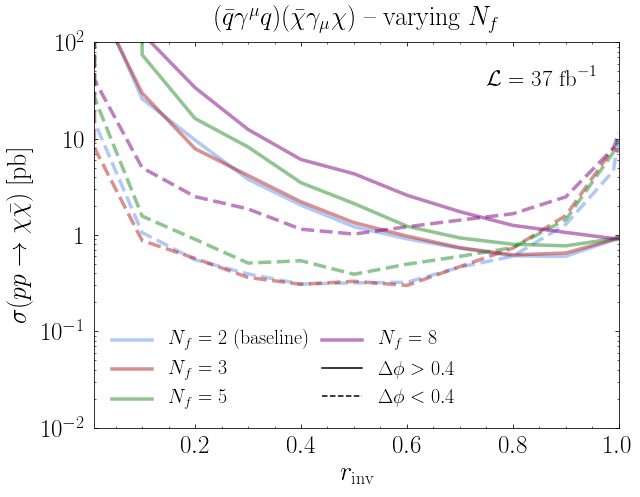

In [68]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$ -- varying $N_f$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r, extra = '', nfiles=16);

    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

contact_cxn_less = result_less*cxn10
contact_cxn_gtr = result_gtr*cxn10


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$N_f = 2$ (baseline)',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'NFf3_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_NFf3, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_NFf3, lw=3.5,
                 color='firebrick', label=r'$N_f = 3$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'NFf5_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_NFf5, lw=3.5, ls='--',
                 color='forestgreen',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_NFf5, lw=3.5,
                 color='forestgreen', label=r'$N_f = 5$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'Nf8_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_NFf8, lw=3.5, ls='--',
                 color='purple',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_NFf10, lw=3.5,
                 color='purple', label=r'$N_f = 8$',alpha=.5)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=fs_labels)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))


plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3,5,7]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],labels[5],labels[7],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,#bbox_to_anchor=(0, 0, 0.97, 0.97),
           fontsize=fs_legend/1.1, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0., 
                 loc='lower left', columnspacing=0.6)




ax = plt.axes()

plt.text(.75,35,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)

# plt.text(.72,.018,"$M_d = 10~\mathrm{GeV}$",fontsize=fs_text)



plt.tight_layout()
plt.savefig("ref_figs/contact_cxn_vary_Nf.pdf")


plt.show()

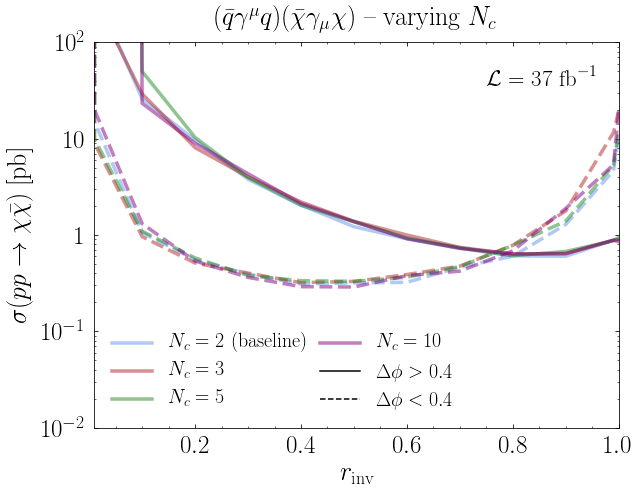

In [69]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$ -- varying $N_c$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r, extra = '', nfiles=16);

    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

contact_cxn_less = result_less*cxn10
contact_cxn_gtr = result_gtr*cxn10


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$N_c = 2$ (baseline)',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'Nc3_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_Nc3, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_Nc3, lw=3.5,
                 color='firebrick', label=r'$N_c = 3$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'Nc5_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_Nc5, lw=3.5, ls='--',
                 color='forestgreen',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_Nc5, lw=3.5,
                 color='forestgreen', label=r'$N_c = 5$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'Nc10_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_Nc10, lw=3.5, ls='--',
                 color='purple',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_Nc10, lw=3.5,
                 color='purple', label=r'$N_c = 10$',alpha=.5)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=fs_labels)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))


plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3,5,7]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],labels[5],labels[7],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,#bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend/1.1, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0., 
                 loc='lower left', columnspacing=0.6)




ax = plt.axes()

plt.text(.75,35,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)

# plt.text(.72,.018,"$M_d = 10~\mathrm{GeV}$",fontsize=fs_text)



plt.tight_layout()
plt.savefig("ref_figs/contact_cxn_vary_Nc.pdf")


plt.show()

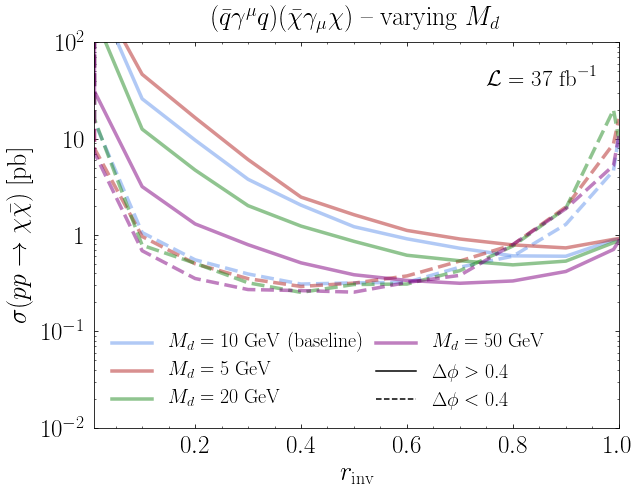

In [71]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$ -- varying $M_d$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r, extra = '', nfiles=16);

    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

contact_cxn_less = result_less*cxn10
contact_cxn_gtr = result_gtr*cxn10


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$M_d = 10$ GeV (baseline)',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'md5_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_mdm5, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_mdm5, lw=3.5,
                 color='firebrick', label=r'$M_d = 5$ GeV',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'md20_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_mdm20, lw=3.5, ls='--',
                 color='forestgreen',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_mdm20, lw=3.5,
                 color='forestgreen', label=r'$M_d = 20$ GeV',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = 'md50_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10_mdm50, lw=3.5, ls='--',
                 color='purple',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10_mdm50, lw=3.5,
                 color='purple', label=r'$M_d = 50$ GeV',alpha=.5)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=fs_labels)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))


plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3,5,7]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],labels[5],labels[7],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,#bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend/1.1, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0., 
                 loc='lower left', columnspacing=0.6)




ax = plt.axes()

plt.text(.75,35,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
# plt.text(.72,.018,"$M_d = 10~\mathrm{GeV}$",fontsize=fs_text)



plt.tight_layout()
plt.savefig("ref_figs/contact_cxn_vary_Md.pdf")


plt.show()

## Table 1: Contact operator cutflow

In [26]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt1 > 250 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > 800'
cuts[2] = ' & MEt > 800 & dphi < 0.4'
cuts[3] = ' & MEt > 800 & dphi > 0.4'

In [27]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut), 3) for bkg in bkgs] for cut in cuts]
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [28]:
rinvs = 0.1, 0.5, 0.9

In [29]:
sigs = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[0] for rinv in rinvs]
cxns = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs]

In [30]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut)/cxn*1,3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [31]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow).astype(np.int32))

In [32]:
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [33]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(rinvs))]

In [34]:
for i in range(len(np.transpose(sig_cutflow))):
    sig_cutflow_pd.insert(2*i+1, 'sig'+str(i+1), sig_sigs[i]) 

In [35]:
for i in range(len(cuts)):
    for j in range(len(rinvs)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [36]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))

In [37]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{llllrrrrr}
\toprule
{} &           0 &           1 &           2 &       0 &       1 &      2 &      3 &      4 \\
\midrule
0 &  2000(2.58) &  4920(6.34) &  2340(3.02) &  225000 &  247000 &  11500 &  57300 &  57300 \\
1 &    43(1.01) &   174(3.94) &   108(2.49) &    1160 &     536 &      6 &     73 &      0 \\
2 &    42(1.81) &   142(5.57) &    35(1.51) &     110 &     326 &      5 &     66 &      0 \\
3 &     0(0.02) &    31(0.89) &     73(2.0) &    1050 &     209 &      0 &      7 &      0 \\
\bottomrule
\end{tabular}



In [7]:
import numpy as np
x = np.array([1,2,3,4])
y = np.array([True, False, True, False])
x[y]

array([1, 3])

In [9]:
mask = np.array([0,0,0,1,1,1]).astype(np.bool)
mask[mask]

array([ True,  True,  True], dtype=bool)